In [1]:
# Современные методы вычислительной математики и механики, 1 семестр, 2021 г.
# Лабораторная работа 2. Методы решения бигармонических уравнений: Метод КНК.
# Решение задачи через глобальную СЛАУ.
# Автор: Горынин А.Г.
###########################
import numpy as np
import scipy as sp
import math
from matplotlib import  pyplot as plt
import copy


N_degree = 4 # степень аппроксимирующего полинома
N_colloc = N_degree+1 # количество точек коллокации
N_eq = N_colloc + 4 # Количество уравнений в локальной матрице

X0 = 0.0
X1 = 1.0
y_ = np.linspace(-1., 1., N_colloc+2, endpoint = True) # локальная система координат


In [2]:
# функция нагрузки 
def f(y, cell_id, Cells, GlobalNodes):
    node1 = Cells[cell_id, 0] # координата левой точки
    node2 = Cells[cell_id, 1] # координата правой точки
    h = (GlobalNodes[node2] - GlobalNodes[node1])/2
    x_c = (GlobalNodes[node2] + GlobalNodes[node1])/2
    x = y*h+x_c # переходим в глобальную систему координат

    return (x**4 + 14*x**3 + 49*x**2 + 32*x - 12)*math.exp(x)
    #return 1

def f_x(x):
    return (x**4 + 14*x**3 + 49*x**2 + 32*x - 12)*math.exp(x)
    

# Вычисление решения по найденным коэффициентам
def u(x, Matrix, Cells, GlobalNodes):
    ## переход в локальную систему
    
    h = (GlobalNodes[1] - GlobalNodes[0])/2
    
    if ( x == X0):
        cell_id = 0
    elif ( x == X1):
        cell_id = len(Cells)-1
    else:
        cell_id = int(x // (2*h)) 

    node1 = Cells[int(cell_id), 0]
    node2 = Cells[int(cell_id), 1]
    x_c = (GlobalNodes[node2] + GlobalNodes[node1])/2
    y = (x-x_c)/h # перешли в локальную систему в нужной ячейке
    # вычисляем значение искомой функции в точке y
    ans = sum([Matrix[cell_id*(N_degree+1) + i]*y**i for i in range(N_degree+1)])
    return ans

# Точное решение
def u_exact(x):
    u = x**2*(1-x)**2*math.exp(x)  
    #u = x**4/24 -x**3/(12)  + x**2/24
    return u



In [3]:
def left_cell(GlobalMatrix, GlobalVector, Cells, GlobalNodes):

    # граничные условия
    GlobalMatrix[0, 0:N_degree+1] = [y_[0]**(j) for j in range(N_degree+1)]
    GlobalMatrix[1, 0:N_degree+1] = [j*y_[0]**(j-1) for j in range(N_degree+1)]
    GlobalVector[0] = 0
    GlobalVector[1] = 0

    # условия согласования
    GlobalMatrix[N_eq-2, 0:N_degree+1] = [y_[-1]**j + j*y_[-1]**(j-1)  for j in range(N_degree+1)]
    GlobalMatrix[N_eq-1, 0:N_degree+1] = [j*(j-1)*y_[-1]**(j-2) + j*(j-1)*(j-2)*y_[-1]**(j-3)  for j in range(N_degree+1)]
    GlobalVector[N_eq-2] = 0
    GlobalVector[N_eq-1] = 0
    GlobalMatrix[N_eq-2, 1*(N_degree+1): 2*(N_degree+1)] = [-( y_[0]**j + j*y_[0]**(j-1) )  for j in range(N_degree+1)]
    GlobalMatrix[N_eq-1, 1*(N_degree+1): 2*(N_degree+1)] = [- ( j*(j-1)*y_[0]**(j-2) + j*(j-1)*(j-2)*y_[0]**(j-3) )  for j in range(N_degree+1)]

    step = GlobalNodes[1] - GlobalNodes[0]
    # условия коллокаций
    for i in range(2, N_colloc+2):
        for j in range(4, N_degree+1):
            GlobalMatrix[i,j] = j*(j-1)*(j-2)*(j-3)*y_[i-1]**(j-4)
        GlobalVector[i] = (step/2)**4*f(y_[i-1], 0 , Cells, GlobalNodes)

def right_cell(i_cell, GlobalMatrix, GlobalVector, Cells, GlobalNodes):
    index = (i_cell)*N_eq 
    index_row  = (i_cell)*(N_degree+1)
    # граничные условия
    GlobalMatrix[index, index_row + 0: index_row + N_degree+1] = [y_[0]**j - j*y_[0]**(j-1)  for j in range(N_degree+1)]
    GlobalMatrix[index + 1, index_row + 0: index_row + N_degree+1] = [j*(j-1)*y_[0]**(j-2) - j*(j-1)*(j-2)*y_[0]**(j-3)  for j in range(N_degree+1)]
    GlobalVector[index + 0] = 0
    GlobalVector[index + 1] = 0

    # условия согласования
    GlobalMatrix[index + N_eq-2, index_row + 0: index_row + N_degree+1] = [y_[-1]**(j) for j in range(N_degree+1)]
    GlobalMatrix[index + N_eq-1, index_row + 0: index_row + N_degree+1] = [j*y_[-1]**(j-1) for j in range(N_degree+1)]
    GlobalVector[index + N_eq-2] = 0
    GlobalVector[index + N_eq-1] = 0
    GlobalMatrix[index, index_row -1*(N_degree+1): index_row - 0*(N_degree+1)] = [-( y_[-1]**j - j*y_[-1]**(j-1) )  for j in range(N_degree+1)]
    GlobalMatrix[index + 1, index_row - 1*(N_degree+1): index_row - 0*(N_degree+1)] = [- ( j*(j-1)*y_[-1]**(j-2) - j*(j-1)*(j-2)*y_[-1]**(j-3) )  for j in range(N_degree+1)]

    step = GlobalNodes[1] - GlobalNodes[0]
    # условия коллокаций
    for i in range(2, N_colloc+2):
        for j in range(4, N_degree+1):
            GlobalMatrix[index + i,index_row + j] = j*(j-1)*(j-2)*(j-3)*y_[i-1]**(j-4)
        GlobalVector[index + i] = (step/2)**4*f(y_[i-1], i_cell , Cells, GlobalNodes)


def inner_cell(i_cell, GlobalMatrix, GlobalVector, Cells, GlobalNodes):
    index = (i_cell)*N_eq 
    index_row  = (i_cell)*(N_degree+1)
    
    # условия согласования
    GlobalMatrix[index, index_row + 0 : index_row + N_degree+1] = [y_[0]**j - j*y_[0]**(j-1)  for j in range(N_degree+1)]
    GlobalMatrix[index + 1, index_row + 0 : index_row + N_degree+1] = [j*(j-1)*y_[0]**(j-2) - j*(j-1)*(j-2)*y_[0]**(j-3)  for j in range(N_degree+1)]
    GlobalVector[index + 0] = 0
    GlobalVector[index + 1] = 0
    GlobalMatrix[index, index_row -1*(N_degree+1): index_row - 0*(N_degree+1)] = [-( y_[-1]**j - j*y_[-1]**(j-1) )  for j in range(N_degree+1)]
    GlobalMatrix[index + 1, index_row - 1*(N_degree+1): index_row - 0*(N_degree+1)] = [- ( j*(j-1)*y_[-1]**(j-2) - j*(j-1)*(j-2)*y_[-1]**(j-3) )  for j in range(N_degree+1)]


    # условия согласования
    GlobalMatrix[index + N_eq-2, index_row + 0 : index_row + N_degree+1] = [y_[-1]**j + j*y_[-1]**(j-1)  for j in range(N_degree+1)]
    GlobalMatrix[index + N_eq-1, index_row + 0 : index_row + N_degree+1] = [j*(j-1)*y_[-1]**(j-2) + j*(j-1)*(j-2)*y_[-1]**(j-3)  for j in range(N_degree+1)]
    GlobalVector[index + N_eq-2] = 0
    GlobalVector[index + N_eq-1] = 0
    GlobalMatrix[index + N_eq-2, index_row + 1*(N_degree+1) : index_row + 2*(N_degree+1)] = [-( y_[0]**j + j*y_[0]**(j-1) )  for j in range(N_degree+1)]
    GlobalMatrix[index + N_eq-1, index_row + 1*(N_degree+1) : index_row + 2*(N_degree+1)] = [- ( j*(j-1)*y_[0]**(j-2) + j*(j-1)*(j-2)*y_[0]**(j-3) )  for j in range(N_degree+1)]

    step = GlobalNodes[1] - GlobalNodes[0]
    # условия коллокаций
    for i in range(2, N_colloc+2):
        for j in range(4, N_degree+1):
            GlobalMatrix[index + i,index_row + j] = j*(j-1)*(j-2)*(j-3)*y_[i-1]**(j-4)
        GlobalVector[index + i] = (step/2)**4*f(y_[i-1], i_cell , Cells, GlobalNodes)


[[  1.  -1.   1.  -1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [ -0.   1.  -2.   3.  -4.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  24.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  24.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  24.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  24.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  24.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  1.   2.   3.   4.   5.  -1.  -0.   1.  -2.   3.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [  0.   0.   2.  12.  36.  -0.  -0.  -2.  -0.  12.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]
 [ -1.  -0.   1.   2.   3.   1.  -2.   3.  -4.   5.   0

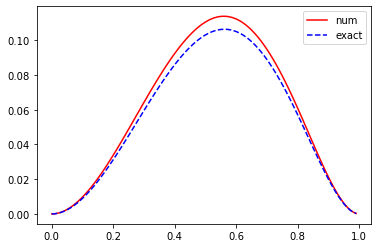

In [4]:
def _solve(N_elements):
    
    N_cells = N_elements  # Количество ячеек
    step = (X1-X0)/N_cells
    X = np.arange(X0, X1, step)  # create a numpy array from X0 to X1 with step
    # Создаем массив узлов (границы ячеек) 
    GlobalNodes = np.linspace(X0,X1, N_cells+1, endpoint = True) 
    # Массив индексов узлов
    NodesID = np.arange(N_cells+1, dtype = int) # 
    # Массив ячеек. Каждой ячейке соответсвуют два узла на левом и на правом краю.
    Cells = np.array([ [i,i+1] for i in range(N_cells)])

    LocalMatrix = np.zeros((N_eq, N_degree+1))
    LocalVector = np.zeros(N_eq)
    GlobalMatrix = np.zeros((N_cells*N_eq, (N_degree+1)*N_cells))
    GlobalVector = np.zeros(N_cells*N_eq)
    
    GlobalMatrix.fill(0)
    GlobalVector.fill(0)

    left_cell(GlobalMatrix, GlobalVector, Cells, GlobalNodes)
    for i in range(1, N_cells-1):
        inner_cell(i, GlobalMatrix, GlobalVector, Cells, GlobalNodes)
    right_cell(N_cells-1, GlobalMatrix, GlobalVector, Cells, GlobalNodes)

    ans = np.linalg.lstsq(GlobalMatrix, GlobalVector, rcond = None)[0]
    Cond_A = np.linalg.cond(GlobalMatrix)
    
    return ans, copy.deepcopy(Cells), copy.deepcopy(GlobalNodes), Cond_A, GlobalMatrix, GlobalVector
    

# Отрисовка решения
def plot_solution(Solution):
    # достаточно мелкая сетка, для сравнения решений и отрисовки
    X_cor = np.arange(X0, X1, 0.01)
    # значение численного решения сетке
    u_ = np.array([u(i, Solution[0], Solution[1], Solution[2]) for i in X_cor])
    # значение точного решения на сетке
    u_ex = np.array([u_exact(i) for i in X_cor])
    # рисуем численное решение
    plt.plot(X_cor, u_, 'r-', label ='num')
    # рисуем точное решение
    plt.plot(X_cor, u_ex, 'b--', label = 'exact')
    plt.legend()

# пробный тест
ans = _solve(4)
plot_solution(ans)
# выводим матрицу, она совпадает с тем, что указана в задании, значит матрица собрана верно
# примечание: порядок строк реализован иначе чем в задании: 2 краевых условия, коллокации, 2 краевых условия
print(ans[4])

Time in seconds: 0.00299835205078125
5
Time in seconds: 0.007997989654541016
10
Time in seconds: 0.012998104095458984
20
Time in seconds: 0.03799843788146973
40
Time in seconds: 0.09299492835998535
80


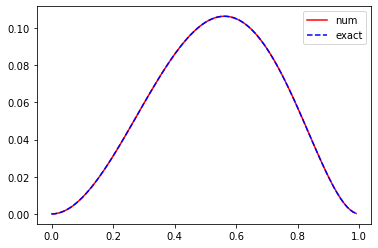

In [5]:
import time
# решаем задачу на последовательности сеток, начиная с 5

i=5
Solution_array = [  ]
error = []
X_cor = np.arange(X0, X1, 0.01)
u_ex = np.array([u_exact(i) for i in X_cor])

# засекаем время
start = time.time() 
cur_time = start       
while i < 81:
    # решаем задачу
    ans = _solve(i)
    print("Time in seconds:", time.time()-cur_time)
    cur_time = time.time()
    # сохраняем решение в массив решений
    Solution_array.append(ans)
    # восстанавливаем решение
    u_ = np.array([u(i, ans[0], ans[1], ans[2]) for i in X_cor])
    # вычисляем относительную погрешность
    error.append(np.max(abs(u_-u_ex))/np.max(abs(u_ex)))  
    print(i)
    i=i*2
# отрисовка последнего решения (можно поменять на любое из массива решений)
plot_solution(Solution_array[-1])

In [6]:
# импортируем утилиту для отрисовки красивых таблиц
# для установки в коммандной строке прописать: pip install prettytable
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Mesh", "Error_relative", "Order",  "Cond_A"]

rate = []
for i in range(len(error)-1):
    rate.append(np.log2(error[i]/error[i+1]))
    x.add_row([5*2**(i), "{:2.2e}".format(error[i]), "{:2.2e}".format(rate[i]),  "{:2.2e}".format(Solution_array[i][3])])
print(x)

+------+----------------+----------+----------+
| Mesh | Error_relative |  Order   |  Cond_A  |
+------+----------------+----------+----------+
|  5   |    4.40e-02    | 2.04e+00 | 1.09e+03 |
|  10  |    1.07e-02    | 2.01e+00 | 1.61e+04 |
|  20  |    2.64e-03    | 2.00e+00 | 2.55e+05 |
|  40  |    6.59e-04    | 2.00e+00 | 4.07e+06 |
+------+----------------+----------+----------+
